# Proyecto 3
## Laboratorio de Análisis Estadístico
## Integrantes
- Ana Sofía Hinojosa
- Julia Hernández
- Sara Hernández

# Objetivos

### Generales

Desarrollar un modelo de clasificación supervisada que prediga la aprobación de solicitudes crediticias, optimizando sus hiperparámetros mediante optimización bayesiana, para maximizar la discriminación entre aprobaciones y rechazos y obtener un alto desempeño general (alto AUC-ROC), de modo que el modelo pueda servir como una herramienta de apoyo a decisiones de crédito confiable y reproducible.

### Específicos

1. Preprocesamiento de datos:

Preprocesar los datos eliminando columnas irrelevantes, convirtiendo variables categóricas en dummies y estandarizando las variables numéricas para que sean comparables.

2. Implementación de Random Forest:

Entrenar y validar un modelo Random Forest mediante validación cruzada de K-Folds, evaluando su desempeño en la predicción de aprobación crediticia, y analizar su capacidad discriminativa utilizando métricas como ROC AUC y la matriz de confusión.

3. Implementación de XGBoost:

Desarrollar un modelo XGBoost para la clasificación de solicitudes crediticias, aplicando validación cruzada de K-Folds para medir su estabilidad y compararlo con Random Forest en términos de capacidad predictiva, ROC AUC y matriz de confusión.

4. Optimización de hiperparámetros:

Aplicar técnicas de optimización automatizada bayesiana mediante Optuna para identificar la configuración óptima de hiperparámetros en Random Forest y XGBoost, maximizando el desempeño del modelo según la métrica ROC AUC.

5. Comparación y selección del mejor modelo:

Comparar el desempeño de los modelos entrenados, Random Forest y XGBoost, tanto en su versión base como optimizada, utilizando métricas como ROC AUC, curvas ROC, matrices de confusión y medidas de precisión. Identificar el modelo con mayor capacidad para discriminar entre solicitudes aprobadas y no aprobadas, e interpretar los resultados para orientar mejoras futuras, incluyendo posible balanceo de clases, selección de características o ajustes adicionales en los hiperparámetros.

# Marco Teórico

### Regresión lineal

#### 6 problemas potenciales en una regresión (ISLP)

### Árbol para regresión

### Árbol para clasificación

### Bootstrap

### Ensambles de modelos

### Bagging

### Boosting

### Tema elegido para proyecto


## Análisis del dataset

## Modelos propuestos

### Random Forest para clasificación

### XGBoost para clasificación

## Pipeline
![La imagen del pipeline se puede encontrar en el repositorio como 'pipeline.jpeg'](pipeline.jpg)

## Código

### Importación de librerías

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
import numpy as np
import random
import os

import warnings
warnings.filterwarnings("ignore")

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)


/Users/sofia/Desktop/séptimo/Proyecto3LabAprEstadistico/venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Análisis del dataset

In [2]:
data = pd.read_csv('Loan_approval_data_2025.csv')
data = data.drop(columns=['customer_id'])
data = data.dropna()

In [3]:
info_df = pd.DataFrame({
    'column': data.columns,
    'dtype': data.dtypes.values,
    'non_nulls': data.notnull().sum().values,
    'nulls': data.isnull().sum().values
})

info_df

,column,dtype,non_nulls,nulls
0,age,int64,50000,0
1,occupation_status,object,50000,0
2,years_employed,float64,50000,0
3,annual_income,int64,50000,0
4,credit_score,int64,50000,0
5,credit_history_years,float64,50000,0
6,savings_assets,int64,50000,0
7,current_debt,int64,50000,0
8,defaults_on_file,int64,50000,0
9,delinquencies_last_2yrs,int64,50000,0


In [4]:
data = pd.get_dummies(data, columns=['product_type', 'occupation_status', 'loan_intent'], drop_first=True)
data

,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,...,loan_status,product_type_Line of Credit,product_type_Personal Loan,occupation_status_Self-Employed,occupation_status_Student,loan_intent_Debt Consolidation,loan_intent_Education,loan_intent_Home Improvement,loan_intent_Medical,loan_intent_Personal
0,40,17.2,25579,692,5.3,895,10820,0,0,0,...,1,False,False,False,False,False,False,False,False,False
1,33,7.3,43087,627,3.5,169,16550,0,1,0,...,0,False,True,False,False,False,False,True,False,False
2,42,1.1,20840,689,8.4,17,7852,0,0,0,...,1,False,False,False,True,True,False,False,False,False
3,53,0.5,29147,692,9.8,1480,11603,0,1,0,...,1,False,False,False,True,False,False,False,False,False
4,32,12.5,63657,630,7.2,209,12424,0,0,0,...,1,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,35,4.3,39449,570,16.3,1127,7576,0,0,0,...,0,False,False,False,False,False,True,False,False,False
49996,34,4.4,20496,672,12.6,1478,6276,1,0,0,...,0,False,False,False,False,False,False,False,False,True
49997,41,4.8,18743,719,10.1,17,10331,0,0,0,...,0,False,False,True,False,False,False,False,False,True
49998,38,0.4,17250,633,1.3,5,7779,0,0,1,...,0,False,True,False,True,False,False,False,False,True


In [5]:
X = data.drop('loan_status', axis=1)
y = data['loan_status']
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numerical_cols] = StandardScaler().fit_transform(X[numerical_cols])
X

,age,years_employed,annual_income,credit_score,credit_history_years,savings_assets,current_debt,defaults_on_file,delinquencies_last_2yrs,derogatory_marks,...,payment_to_income_ratio,product_type_Line of Credit,product_type_Personal Loan,occupation_status_Self-Employed,occupation_status_Student,loan_intent_Debt Consolidation,loan_intent_Education,loan_intent_Home Improvement,loan_intent_Medical,loan_intent_Personal
0,0.453563,1.280229,-0.750345,0.747482,-0.397958,-0.204093,-0.262046,-0.237701,-0.656347,-0.357489,...,-1.455529,False,False,False,False,False,False,False,False,False
1,-0.176018,-0.020345,-0.213787,-0.256675,-0.647698,-0.258959,0.170615,-0.237701,0.527028,-0.357489,...,1.146448,False,True,False,False,False,False,True,False,False
2,0.633444,-0.834846,-0.895579,0.701137,0.032151,-0.270446,-0.486154,-0.237701,-0.656347,-0.357489,...,-1.288075,False,False,False,True,True,False,False,False,False
3,1.622787,-0.913669,-0.640998,0.747482,0.226393,-0.159883,-0.202923,-0.237701,0.527028,-0.357489,...,-1.294515,False,False,False,True,False,False,False,False,False
4,-0.265959,0.662785,0.416612,-0.210330,-0.134343,-0.255936,-0.140931,-0.237701,-0.656347,-0.357489,...,1.854907,False,True,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0.003862,-0.414459,-0.325278,-1.137244,1.128234,-0.186561,-0.506994,-0.237701,-0.656347,-0.357489,...,0.824421,False,False,False,False,False,True,False,False,False
49996,-0.086078,-0.401322,-0.906121,0.438511,0.614879,-0.160035,-0.605155,4.206968,-0.656347,-0.357489,...,-1.107740,False,False,False,False,False,False,False,False,True
49997,0.543504,-0.348773,-0.959844,1.164594,0.268017,-0.270446,-0.298970,-0.237701,-0.656347,-0.357489,...,0.553919,False,False,True,False,False,False,False,False,True
49998,0.273683,-0.926806,-1.005600,-0.163984,-0.952937,-0.271353,-0.491666,-0.237701,-0.656347,2.063865,...,-1.333159,False,True,False,True,False,False,False,False,True


### Modelos

In [6]:
model_random_forest = RandomForestClassifier(n_estimators=100, random_state=42)
model_xgboost = xgb.XGBClassifier(eval_metric='logloss', tree_method='hist', n_estimators=100, random_state=42)
k_folds = KFold(n_splits=5, shuffle=True, random_state=42)

In [7]:
variables_importances_random_forest = pd.DataFrame({
    'feature': X.columns,
    'importance_random_forest': model_random_forest.fit(X, y).feature_importances_,
}).sort_values(by='importance_random_forest', ascending=False)

variables_importances_random_forest

,feature,importance_random_forest
3,credit_score,0.204656
12,debt_to_income_ratio,0.169741
11,interest_rate,0.066342
4,credit_history_years,0.064787
8,delinquencies_last_2yrs,0.062069
0,age,0.046416
13,loan_to_income_ratio,0.045991
14,payment_to_income_ratio,0.044099
7,defaults_on_file,0.039897
1,years_employed,0.039123


In [8]:
variables_importances_xgboost = pd.DataFrame({
    'feature': X.columns,
    'importance_xgboost': model_xgboost.fit(X, y).feature_importances_,
}).sort_values(by='importance_xgboost', ascending=False)

variables_importances_xgboost

,feature,importance_xgboost
7,defaults_on_file,0.160836
3,credit_score,0.136706
12,debt_to_income_ratio,0.079668
8,delinquencies_last_2yrs,0.078596
19,loan_intent_Debt Consolidation,0.065321
23,loan_intent_Personal,0.063546
20,loan_intent_Education,0.062345
14,payment_to_income_ratio,0.054532
22,loan_intent_Medical,0.051371
9,derogatory_marks,0.038310


In [9]:
scores_random_forest = cross_val_score(
    model_random_forest, X, y, cv=k_folds, scoring='roc_auc', n_jobs=-1
)

scores_xgboost = cross_val_score(
    model_xgboost, X, y, cv=k_folds, scoring='roc_auc', n_jobs=-1,
)

print("Random Forest Classifier ROC AUC: %.2f%% (+/- %.2f%%)" % 
      (scores_random_forest.mean()*100, scores_random_forest.std()*100))

print("XGBoost Classifier ROC AUC: %.2f%% (+/- %.2f%%)" % 
      (scores_xgboost.mean()*100, scores_xgboost.std()*100))

Random Forest Classifier ROC AUC: 97.29% (+/- 0.11%)
XGBoost Classifier ROC AUC: 98.32% (+/- 0.07%)


### Optimización de hiperparámetros

In [10]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
def objective_random_forest(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 800),
        "max_depth": trial.suggest_categorical("max_depth", [None, 5, 10, 20, 30]),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
    }
    model = RandomForestClassifier(**params, n_jobs=-1)

    scores = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    trial.set_user_attr("std", float(scores.std()))

    return scores.mean()

study_random_forest = optuna.create_study(direction="maximize")
study_random_forest.optimize(objective_random_forest, n_trials=50, show_progress_bar=True)  

print("Best Random Forest Parameters:")
print(study_random_forest.best_trial.params)

print("Mean ROC AUC:", study_random_forest.best_trial.value)
print("Std ROC AUC:", study_random_forest.best_trial.user_attrs["std"])

Best trial: 43. Best value: 0.974154: 100%|██████████| 50/50 [17:22<00:00, 20.84s/it]

Best Random Forest Parameters:
{'n_estimators': 669, 'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 1}
Mean ROC AUC: 0.9741536641856662
Std ROC AUC: 0.0013941100461094965


In [11]:
def objective_xgboost(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 600),
        "max_depth": trial.suggest_int("max_depth", 2, 12),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "tree_method": "hist",
        "eval_metric": "logloss",
    }

    model = xgb.XGBClassifier(**params, n_jobs=-1)

    scores = cross_val_score(
        model,
        X,
        y,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )

    trial.set_user_attr("std", float(scores.std()))

    return scores.mean()

study_xgboost = optuna.create_study(direction="maximize")
study_xgboost.optimize(objective_xgboost, n_trials=50, show_progress_bar=True) 

print("Best XGBoost Classifier Trial:")
print(study_xgboost.best_trial.params)

print("Mean ROC AUC:", study_xgboost.best_trial.value)
print("Std ROC AUC:", study_xgboost.best_trial.user_attrs["std"])

Best trial: 40. Best value: 0.98534: 100%|██████████| 50/50 [00:44<00:00,  1.13it/s] 

Best XGBoost Classifier Trial:
{'n_estimators': 269, 'max_depth': 3, 'gamma': 1.770670035842893, 'learning_rate': 0.18688686778834707}
Mean ROC AUC: 0.9853397370169764
Std ROC AUC: 0.00035075992702841873


### Resultados

#### ROC AUC antes de optimizar

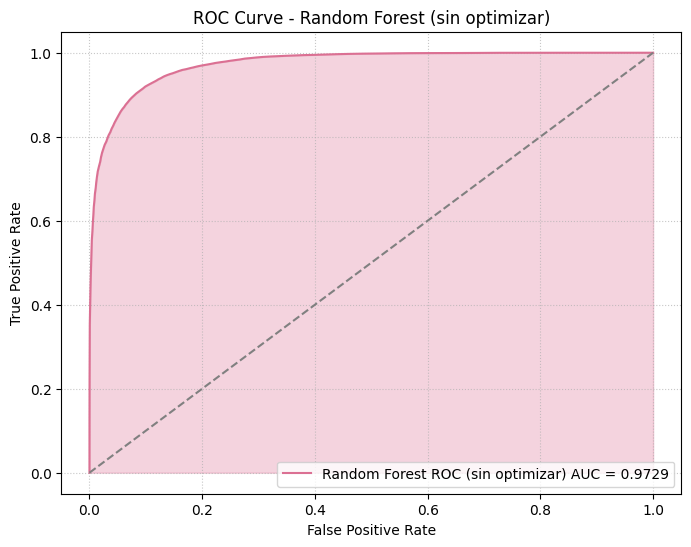

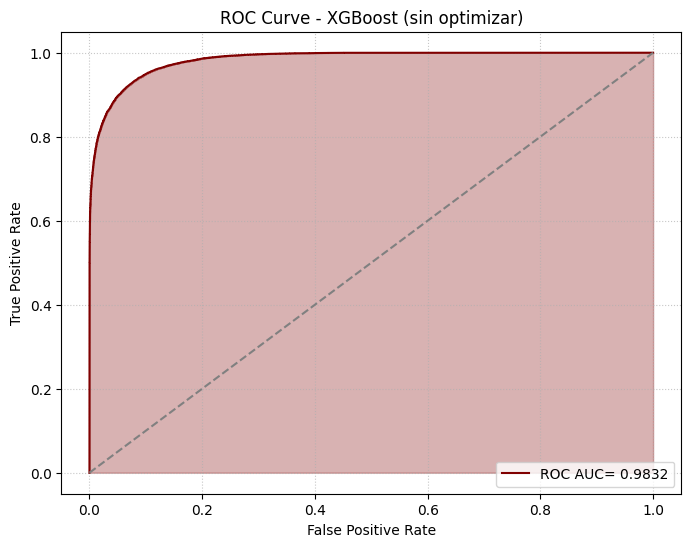

In [12]:
y_pred_sin_opt_rf = cross_val_predict(
    model_random_forest, X, y, cv=k_folds, method='predict_proba', n_jobs=-1
)[:, 1]

y_pred_sin_opt_xgb = cross_val_predict(
    model_xgboost, X, y, cv=k_folds, method='predict_proba', n_jobs=-1
)[:, 1]

fpr_sin_opt_rf, tpr_sin_opt_rf, _ = roc_curve(y, y_pred_sin_opt_rf)
fpr_sin_opt_xgb, tpr_sin_opt_xgb, _ = roc_curve(y, y_pred_sin_opt_xgb)

roc_auc_sin_opt_rf = roc_auc_score(y, y_pred_sin_opt_rf)
roc_auc_sin_opt_xgb = roc_auc_score(y, y_pred_sin_opt_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_sin_opt_rf, tpr_sin_opt_rf,
         label=f'Random Forest ROC (sin optimizar) AUC = {roc_auc_sin_opt_rf:.4f}',
         color='palevioletred')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.fill_between(fpr_sin_opt_rf, tpr_sin_opt_rf, alpha=0.3, color='palevioletred')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest (sin optimizar)")
plt.legend(loc='lower right')
plt.grid(linestyle=':', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr_sin_opt_xgb, tpr_sin_opt_xgb,
         label=f'ROC AUC= {roc_auc_sin_opt_xgb:.4f}',
         color='maroon')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.fill_between(fpr_sin_opt_xgb, tpr_sin_opt_xgb, alpha=0.3, color='maroon')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost (sin optimizar)")
plt.legend(loc='lower right')
plt.grid(linestyle=':', alpha=0.7)
plt.show()



### Matrices de confusión antes de optimizar

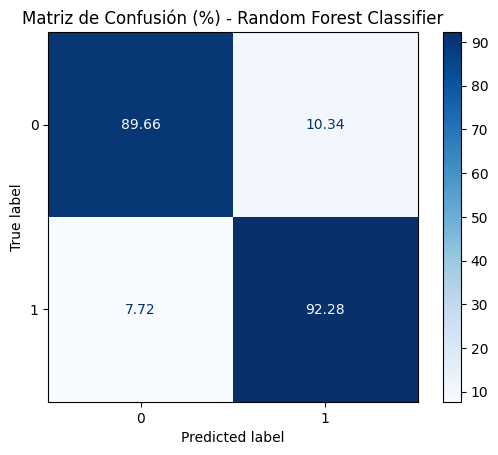

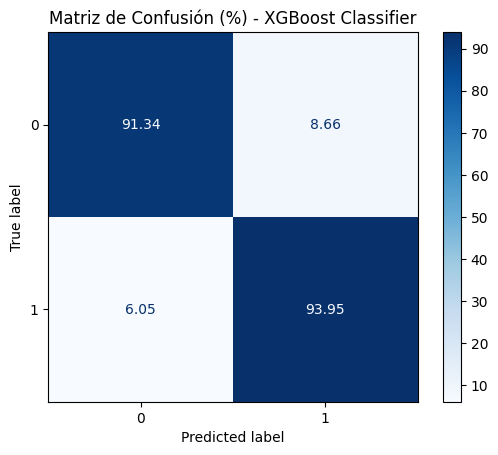

In [19]:
matriz_rf = cross_val_predict(model_random_forest, X, y, cv=k_folds, n_jobs=-1)
matriz_xgb = cross_val_predict(model_xgboost, X, y, cv=k_folds, n_jobs=-1)

cm_rf = confusion_matrix(y, matriz_rf, normalize='true') * 100
cm_xgb = confusion_matrix(y, matriz_xgb, normalize='true') * 100

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot(cmap='Blues', values_format='.2f') 
plt.title('Matriz de Confusión (%) - Random Forest Classifier')

disp_xgb = ConfusionMatrixDisplay(confusion_matrix=cm_xgb)
disp_xgb.plot(cmap='Blues', values_format='.2f')
plt.title('Matriz de Confusión (%) - XGBoost Classifier')

plt.show()


#### Resultados de la optimización

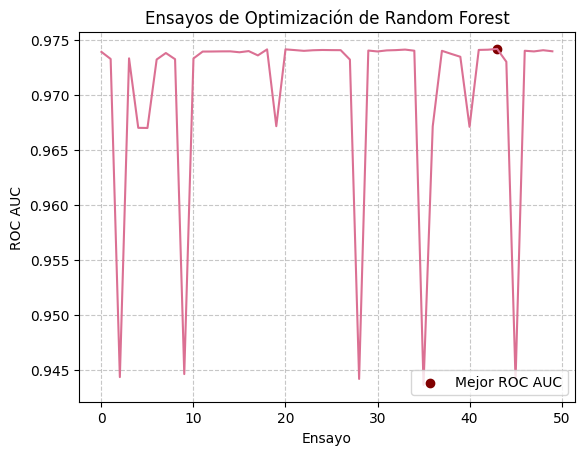

In [31]:
df_optim_rf = pd.DataFrame(study_random_forest.trials_dataframe())
best_value = df_optim_rf['value'].max()
plt.plot(df_optim_rf['value'], color='palevioletred')
plt.title('Ensayos de Optimización de Random Forest')
plt.scatter(df_optim_rf.index[df_optim_rf['value'] == best_value],
            best_value,
            color='maroon',
            label='Mejor ROC AUC')
plt.xlabel('Ensayo')
plt.ylabel('ROC AUC')
plt.grid(linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.show()

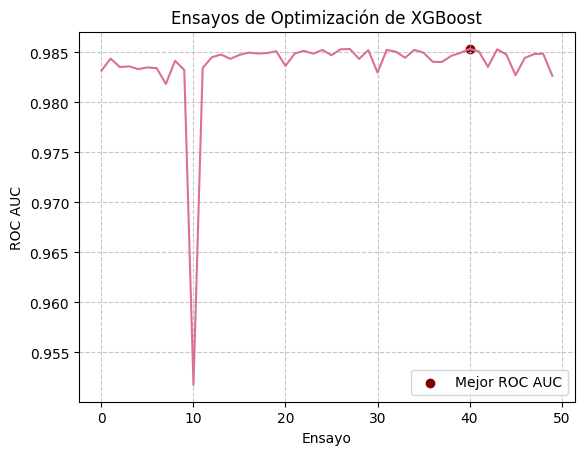

In [32]:
df_optim_xgb = pd.DataFrame(study_xgboost.trials_dataframe())
best_value = df_optim_xgb['value'].max()
plt.plot(df_optim_xgb['value'], color='palevioletred')
plt.title('Ensayos de Optimización de XGBoost')
plt.scatter(df_optim_xgb.index[df_optim_xgb['value'] == best_value],
            best_value,
            color='maroon',
            label='Mejor ROC AUC')
plt.xlabel('Ensayo')
plt.ylabel('ROC AUC')
plt.grid(linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.show()

### Hiperparámetros óptimos por modelo

In [15]:
pd.DataFrame({
    "Random Forest": study_random_forest.best_trial.params,
})

,Random Forest
n_estimators,669
max_depth,30
min_samples_split,3
min_samples_leaf,1


In [16]:
pd.DataFrame({
    "XGBoost": study_xgboost.best_trial.params,
})

,XGBoost
n_estimators,269.000000
max_depth,3.000000
gamma,1.770670
learning_rate,0.186887


### ROC AUC después de optimizar

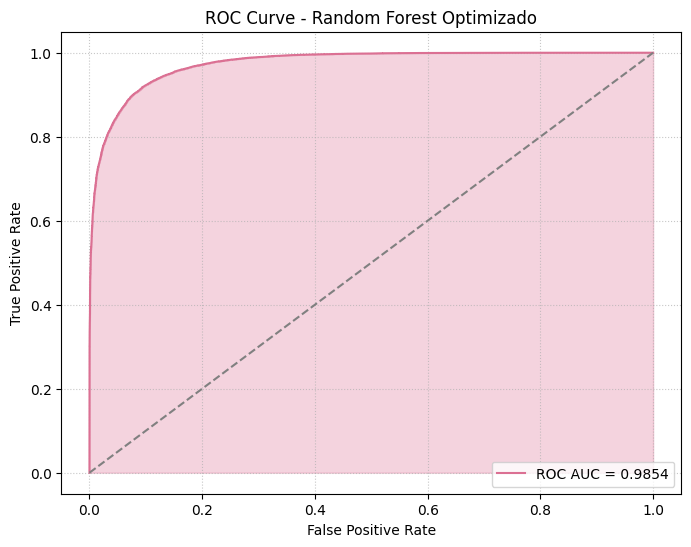

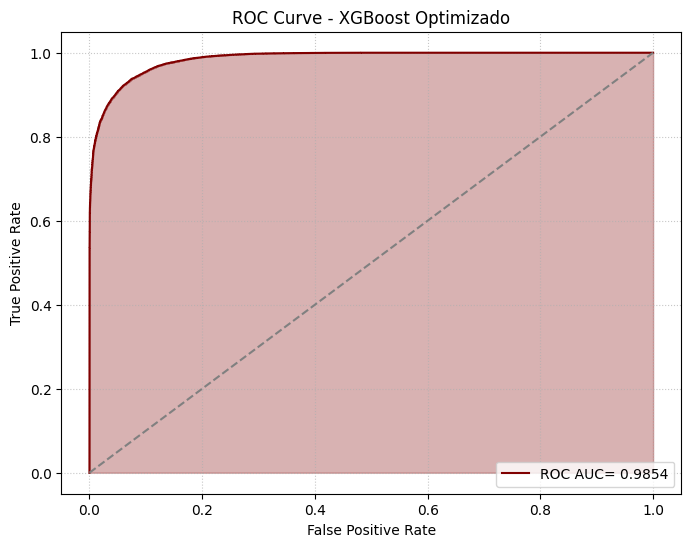

In [18]:
model_rf_best = RandomForestClassifier(**study_random_forest.best_trial.params, n_jobs=-1)
model_xgb_best = xgb.XGBClassifier(**study_xgboost.best_trial.params, n_jobs=-1)

y_pred_opt_rf = cross_val_predict(
    model_rf_best, X, y, cv=k_folds, method='predict_proba', n_jobs=-1
)[:, 1]

y_pred_opt_xgb = cross_val_predict(
    model_xgb_best, X, y, cv=k_folds, method='predict_proba', n_jobs=-1
)[:, 1] 

fpr_opt_rf, tpr_opt_rf, _ = roc_curve(y, y_pred_opt_rf)
roc_auc_opt_rf = roc_auc_score(y, y_pred_opt_xgb)

fpr_opt_xgb, tpr_opt_xgb, _ = roc_curve(y, y_pred_opt_xgb)
roc_auc_opt_xgb = roc_auc_score(y, y_pred_opt_xgb)

plt.figure(figsize=(8, 6))
plt.plot(fpr_opt_rf, tpr_opt_rf,
         label=f'ROC AUC = {roc_auc_opt_rf:.4f}',
         color='palevioletred')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.fill_between(fpr_opt_rf, tpr_opt_rf, alpha=0.3, color='palevioletred')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest Optimizado")
plt.legend(loc='lower right')
plt.grid(linestyle=':', alpha=0.7)
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(fpr_opt_xgb, tpr_opt_xgb,
         label=f'ROC AUC= {roc_auc_opt_xgb:.4f}',
         color='maroon')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.fill_between(fpr_opt_xgb, tpr_opt_xgb, alpha=0.3, color='maroon')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - XGBoost Optimizado")
plt.legend(loc='lower right')
plt.grid(linestyle=':', alpha=0.7)
plt.show()


#### Matrices de confusión después de optimizar

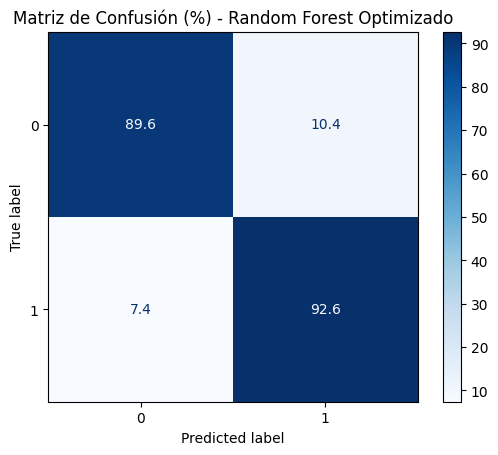

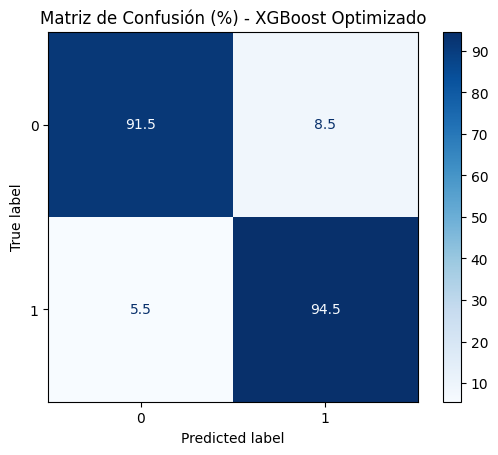

In [20]:
best_params_rf = study_random_forest.best_trial.params

model_rf_best = RandomForestClassifier(
    **best_params_rf,
    n_jobs=-1
)

matriz_rf_best = cross_val_predict(
    model_rf_best,
    X,
    y,
    cv=5,
    method='predict',
    n_jobs=-1
)

cm_rf_best = confusion_matrix(y, matriz_rf_best, normalize='true') * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf_best)
disp.plot(cmap='Blues', values_format='.1f')
plt.title('Matriz de Confusión (%) - Random Forest Optimizado')
plt.show()

best_params_xgb = study_xgboost.best_trial.params

model_xgb_best = xgb.XGBClassifier(
    **best_params_xgb,
    n_jobs=-1,
    tree_method="hist",
    eval_metric="logloss"
)

matriz_xgb_best = cross_val_predict(
    model_xgb_best,
    X,
    y,
    cv=5,
    method='predict',
    n_jobs=-1
)

cm_xgb_best = confusion_matrix(y, matriz_xgb_best, normalize='true') * 100

disp = ConfusionMatrixDisplay(confusion_matrix=cm_xgb_best)
disp.plot(cmap='Blues', values_format='.1f')
plt.title('Matriz de Confusión (%) - XGBoost Optimizado')
plt.show()

#### Tabla comparativa de resultados

In [24]:
tipos = ['Random Forest sin optimización', 'Random Forest optimizado', 'XGBoost sin optimización', 'XGBoost optimizado']
pd.DataFrame({
    "Modelo utilizado": tipos,
    "Promedio de ROC AUC": [
        scores_random_forest.mean(),
        study_random_forest.best_trial.value,
        scores_xgboost.mean(),
        study_xgboost.best_trial.value
    ],
    "Desviación estándar de ROC AUC": [
        scores_random_forest.std(),
        study_random_forest.best_trial.user_attrs["std"],
        scores_xgboost.std(),
        study_xgboost.best_trial.user_attrs["std"]
    ]
})

,Modelo utilizado,Promedio de ROC AUC,Desviación estándar de ROC AUC
0,Random Forest sin optimización,0.972886,0.001142
1,Random Forest optimizado,0.974154,0.001394
2,XGBoost sin optimización,0.983201,0.000686
3,XGBoost optimizado,0.985340,0.000351


## Conclusiones

### Conclusión general

En este proyecto se desarrolló y evaluó un conjunto de modelos de clasificación supervisada con el objetivo de predecir la aprobación de solicitudes crediticias. El proceso inició con un preprocesamiento exhaustivo del dataset, que incluyó la eliminación de valores faltantes, la estandarización de variables numéricas y la transformación de las características necesarias para garantizar su compatibilidad con los algoritmos de machine learning. Este conjunto de pasos aseguró que los modelos trabajaran con datos consistentes, representativos y adecuados para la tarea de clasificación.

Posteriormente, se implementaron dos modelos de referencia: Random Forest y XGBoost, ambos reconocidos por su capacidad para manejar relaciones no lineales y capturar interacciones complejas entre las variables presentes en datos de riesgo crediticio. Cada modelo fue evaluado mediante validación cruzada con k particiones, utilizando métricas de desempeño como ROC AUC, curvas ROC promedio y matrices de confusión. Estos indicadores permitieron medir la capacidad discriminante de cada algoritmo para distinguir entre solicitudes aprobadas y no aprobadas, así como evaluar la estabilidad del rendimiento a lo largo de diferentes subconjuntos del dataset.

Con el fin de maximizar el desempeño predictivo, se aplicó un proceso de optimización automática de hiperparámetros mediante Optuna, utilizando la métrica ROC AUC como criterio principal. Esta optimización exploró de manera eficiente configuraciones clave en ambos modelos, como la profundidad de los árboles, el número de estimadores, la tasa de aprendizaje y parámetros de regularización, logrando mejoras significativas respecto a las versiones base. En particular, XGBoost mostró una capacidad notable para beneficiarse de la optimización, alcanzando un desempeño más alto y consistente.

Los resultados obtenidos permiten concluir que el modelo XGBoost optimizado fue el que presentó el mejor rendimiento global, logrando el mayor ROC AUC y la mejor separación entre clases dentro del espacio ROC. Asimismo, su matriz de confusión mostró una mayor proporción de aciertos en ambas clases, lo que evidencia un equilibrio adecuado entre sensibilidad y especificidad. Por su parte, el Random Forest también mostró un desempeño competitivo, aunque ligeramente inferior al de XGBoost, tanto en la curva ROC como en la matriz de confusión.

En conjunto, el análisis demuestra que los modelos de ensamble basados en árboles resultan altamente efectivos para la predicción de aprobación crediticia, especialmente cuando se combinan con técnicas avanzadas de optimización de hiperparámetros. Finalmente, los hallazgos abren la puerta a futuras mejoras, como la ingeniería de características más sofisticada, el análisis de importancia de variables, el ajuste fino de umbrales de decisión o la integración de técnicas de balanceo en caso de que se enfrenten escenarios con desbalance significativo. De esta manera, el proyecto sienta una base sólida para la construcción de herramientas predictivas confiables y escalables en el ámbito del análisis crediticio.

### Métrico utilizado

**ROC AUC** se eligió porque permite evaluar de forma completa la capacidad del modelo para diferenciar entre solicitudes aprobadas y no aprobadas sin depender de un umbral específico. Esto es especialmente útil en problemas donde el balance entre clases puede variar o donde las consecuencias de los falsos positivos y falsos negativos no son iguales. A diferencia de métricas como el accuracy, que pueden resultar engañosas cuando una clase es mucho más frecuente que la otra, el ROC AUC resume el rendimiento del modelo considerando todas las posibles combinaciones de sensibilidad y tasa de falsos positivos. Además, su interpretación es directa: un valor más alto indica una mayor capacidad para clasificar correctamente ambas clases. Por estas razones, el ROC AUC es ampliamente utilizado en contextos financieros y de riesgo, donde es indispensable contar con métricas estables, comparables entre modelos y capaces de reflejar la verdadera capacidad discriminante del sistema predictivo.
